In [1]:
import numpy as np
import random
import math
import heapq
import ray
from benchmark_parser import all_parser, parser
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gym.spaces import Discrete, MultiDiscrete, Dict
from ray import tune, air
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.agents.ppo import PPOTrainer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env
from my_env import RtGridEnv, MultiEnv, SwitchBenchmarkCallback, PrintEnvCallback
from ray.rllib.algorithms.callbacks import DefaultCallbacks

In [2]:
# Try fine-tuning "kuma" benchmark
env_config = all_parser("/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/benchmarks")
def env_creator(env_config: dict):
    benchmarks = env_config["benchmarks"]
    default_env = env_config.get("default_env", 0)  # Use default value if not provided
    return MultiEnv(benchmarks, default_env)
register_env("multi_env", env_creator)
algo = PPOTrainer(
    env="multi_env", 
    config={"env_config": {"benchmarks": env_config, "default_env": 5}})
checkpoint = "/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/MA_runs/multi_env/checkpoint_004901"
algo.restore(checkpoint)

2023-08-28 15:49:12,506	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='multi_env', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('multi_env').build()` instead. This will raise an error in the future!
2023-08-28 15:49:14,295	INFO worker.py:1538 -- Started a local Ray instance.
(RolloutWorker pid=615328) 2023-08-28 15:49:18,646	WARNING env.py:247 -- Your MultiAgentEnv <MultiEnv instance> does not have some or all of the needed base-class attributes! Make sure you call `super().__init__` from within your MutiAgentEnv's constructor. This will raise an error in the future.
2023-08-28 15:49:19,751	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-08-28 15:49:19,859	INFO trainable.py:790 -- Restored on 10.0.0.82 from checkpoint: /home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/MA_runs/multi_env/checkpoint_004901
2023-08-28 15:49:19,860	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 4901, '_timestep

In [4]:
# Fine tune the algo
rewards = []
checkpoint_dir = "/home/brucexi2/UBC-EECE-597_multi-agent-RL-IC-routing/MA_runs/kuma_FT"
for i in range(2000):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
    if i%100 == 0:
        checkpoint_file = algo.save(checkpoint_dir)
print(rewards)

[-2996.0, -2996.0, -2996.0, -2996.0, -2995.4, -2995.5, -2995.5714285714284, -2995.625, -2995.6666666666665, -2995.7, -2995.4545454545455, -2995.5, -2995.5384615384614, -2995.5714285714284, -2995.6, -2995.625, -2995.6470588235293, -2995.6666666666665, -2995.684210526316, -2995.7, -2995.714285714286, -2995.7272727272725, -2995.7391304347825, -2995.75, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.88, -2995.88, -2987.87, -2987.87, -2987.87, -2987.87, -2987.99, -2987.99, -2987.99, -2987.99, -2987.99, -2987.99, -2987.99, -2987.99, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.87, -2987.75, -2987.75, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.76, -2995.88, -2995.88, -2995.88, -2995.88, -2995.88, -2988.39, -2988.39, -2988.39, -2988.39, -2988.27, -2988.27, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39, -2988.39

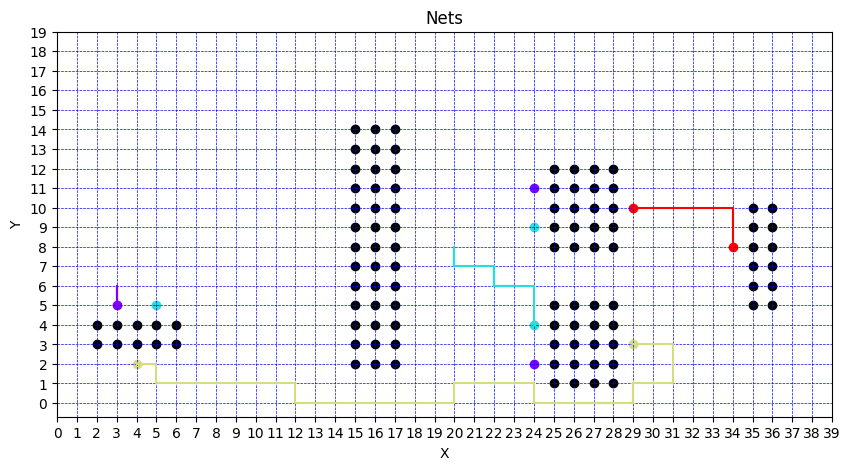

-2027


In [5]:
# Run inference on the fine-tuned algo
env = env_creator({"benchmarks": env_config, "default_env": 5})
num_env = len(env.envs)

n_nets = len(env.current_env.agents_id)
total_reward = 0
obs = env.reset()
done = {}
for i in range(n_nets):
    done["agent_{}".format(i)] = False
done["__all__"] = False
while True:
    action = algo.compute_actions(observations=obs, explore=False)
    # only agents that are not done will be provided an action
    action = {agent: action[agent] for agent in done if not done[agent] and agent != "__all__"}
    obs, reward, done, info = env.step(action)
    total_reward += sum(reward.values())
    if done["__all__"]:
        break
env.current_env.render()
#env.current_env.heatmap()
print(total_reward)